In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.stats import norm
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from gammaALPs.nel.icm import NelICM
from scipy.spatial.transform import Rotation as R_

In [2]:
def cart_to_sphere(x2, y2, z2):
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    theta2 = np.arccos(z2 / r2)
    phi2 = np.arctan2(y2, x2)
    return r2, theta2, phi2

def sphere_to_cart(r, theta, phi):
    x1 = r * np.sin(theta) * np.cos(phi)
    y1 = r * np.sin(theta) * np.sin(phi)
    z1 = r * np.cos(theta)
    return x1, y1, z1


alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2
norm_ = np.sqrt((3 * F_0 + alpha**5)**2) * 2 / (3 * alpha**2)

def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
        #outdata[c, :, :] = mat[:, :]
    
    return mat


def rotation(n, x, angle):
    '''Rotation of vector x around n by angle.'''
    return n * np.inner(n, x) + np.cos(angle) * np.cross(np.cross(n, x), n) + np.sin(angle) * np.cross(n, x)

def cart_rotation(alpha, beta):
    '''Returns rotation matrices in cartesian coordinates x, y, z.'''
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot, y, rot_z

def b_r(r, theta):
    
    zero_val = - np.cos(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = 2 * np.cos(theta) * f(r) / r**2
    if r > 1:
        val = 0
    return 1 / norm_ * val
    

def b_theta(r, theta):
    zero_val = np.sin(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = - np.sin(theta) * f_prime(r) / r
    if r > 1:
        val = 0
    return 1 / norm_ * val


def b_phi(r, theta):
    zero_val = 0
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = alpha * np.sin(theta) * f(r) / r
    if r > 1:
        val = 0
    return 1 / norm_ * val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2 

def rotation_measure(z, b_par, nel):
    #print(z)
    #print(b_par)
    #print(nel)
    return 812 * simps(b_par * nel, z)

def projection(field, direction):
    return np.inner(field, direction)

def axis_helper(x):
    l = x.shape[0]
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx / 2, x[-1] + dx / 2, num=l + 1)


def B(B0, x1, x2, x3, in_sys, out_sys):
    #get input coordinates
    if in_sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif in_sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    
    #calculate bfield
    B = np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])
    #print(B.shape)
    #get output coordinates
    if out_sys == 'sph':
        return B * B0
    elif out_sys == 'cart':
        return B0 * np.matmul(trafo(r, theta, phi), B.transpose()).transpose()

#def kpc_to_arcmin()

def B_rot(B, rotvec):
    return np.matmul(rotvec.as_matrix(), B.transpose()).transpose()

In [151]:
def generate_B_struc(xx, yy, zz, B0, R, theta, phi):

    theta_ = np.radians(theta)
    phi_ = np.radians(phi)
    
    #get rotation
    #incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))    # tilts symmetry axis around x-axis
    pa = R_.from_rotvec(phi_ * np.array([0, 0, 1]))        # rotates around z axis, position angle phi
    
    incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))
    incl = R_.from_rotvec(B_rot(incl.as_rotvec(), pa))

    
    #get magnetic field at each point
    B_r = np.zeros((xx.flatten().shape[0], 3))
    c_list = list(zip(xx.flatten(), yy.flatten(), zz.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            #print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        b_temp = B_rot(B(B0, r_, theta_, phi_, 'sph', 'cart'), incl)
        B_r[c_] = b_temp #B_rot(b_temp, pa)
    B_r = B_r.reshape(*xx.shape, 3)
    return B_r[:, :, :, 2]


def make_3d(R, B0, theta, phi, sphere):
    num=11
    int_steps = 100
    # init electron density model
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    
    #convert angles to radians
    theta_ = np.radians(theta)
    phi_ = np.radians(phi)
    
    #get rotation
    #incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))    # tilts symmetry axis around x-axis
    pa = R_.from_rotvec(phi_ * np.array([0, 0, 1]))        # rotates around z axis, position angle phi
    
    incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))
    incl = R_.from_rotvec(B_rot(incl.as_rotvec(), pa))
    
    #init coordinate space
    dx = 2 * R / num
    x = np.linspace(-R + dx / 2, R - dx / 2, num=num, endpoint=True)
    y = np.linspace(-R + dx / 2, R - dx / 2, num=num, endpoint=True)
    if sphere == 'half':
        z = np.linspace(0, R, num=int_steps, endpoint=True)   # (0, R) for front half sphere, (-R, R) for full sphere, (-R, 0) for back
    elif sphere == 'full':
        z = np.linspace(-R, R, num=2*int_steps, endpoint=True)
    #coordinate meshgrid
    xx, yy, zz = np.meshgrid(x, y, z)
    print(xx)
    #get magnetic field at each point
    B_r = np.zeros((xx.flatten().shape[0], 3))
    c_list = list(zip(xx.flatten(), yy.flatten(), zz.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            #print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        #g = B_cart(r_, theta_, phi_, sys='sph')
        #B_C[c_] = g
        b_temp = B_rot(B(B0, r_, theta_, phi_, 'sph', 'cart'), incl)
        B_r[c_] = b_temp #B_rot(b_temp, pa)
    B_r = B_r.reshape(len(x), len(y), len(z), 3)
    #get rm at each projected point in x-y plane
    rm = np.zeros((x.shape[0],  y.shape[0]))
    rr, _, _ = cart_to_sphere(xx, yy, zz)
    NEL = nel(rr)*1e-3
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_r[i, j, :, 2], NEL[i, j, :])

    #init figure
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect=1)
    tick_pos = (-100, -50, 0, 50, 100)
    ax.set_xticks(tick_pos)
    ax.set_yticks(tick_pos)
    #for plotting s.t. pixels are properly aligned to the middle
    xh = axis_helper(x)
    yh = axis_helper(y)
    xxh, yyh = np.meshgrid(xh, yh)
    print(xxh)
    #set up colormap
    cmap = plt.get_cmap('seismic')
    levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
    norm = BoundaryNorm(levels, cmap.N)
    
    #plot colormap
    cbticks = np.arange(-1e4, +1.2e4, step=2e3, dtype=int)
    pcol = ax.pcolor(xxh, yyh, rm, cmap=cmap, norm=norm, alpha=1)
    cb = fig.colorbar(pcol, ax=ax, extend='both', ticks=cbticks)
    ticklabels = cb.ax.get_yticklabels()
    cb.ax.set_yticklabels(ticklabels, ha='right')
    cb.ax.set_ylabel(r'RM [\SI{}{\radian\per\meter\squared}]', labelpad=10)
    cb.ax.yaxis.set_tick_params(pad=35)
    #cb.ax.yaxis.set_ticks(cbticks, cbticks)
    #text with central RM
    props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
    # place a text box in upper left in axes coords
    textstr = ' '.join((f'central RM: {rm[5, 5]:.0f}', r'\SI{}{\radian\per\meter\squared}'))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.scatter(x, np.zeros(x.shape))
    return rm

[[[-84.54545455 -84.54545455 -84.54545455 ... -84.54545455 -84.54545455
   -84.54545455]
  [-67.63636364 -67.63636364 -67.63636364 ... -67.63636364 -67.63636364
   -67.63636364]
  [-50.72727273 -50.72727273 -50.72727273 ... -50.72727273 -50.72727273
   -50.72727273]
  ...
  [ 50.72727273  50.72727273  50.72727273 ...  50.72727273  50.72727273
    50.72727273]
  [ 67.63636364  67.63636364  67.63636364 ...  67.63636364  67.63636364
    67.63636364]
  [ 84.54545455  84.54545455  84.54545455 ...  84.54545455  84.54545455
    84.54545455]]

 [[-84.54545455 -84.54545455 -84.54545455 ... -84.54545455 -84.54545455
   -84.54545455]
  [-67.63636364 -67.63636364 -67.63636364 ... -67.63636364 -67.63636364
   -67.63636364]
  [-50.72727273 -50.72727273 -50.72727273 ... -50.72727273 -50.72727273
   -50.72727273]
  ...
  [ 50.72727273  50.72727273  50.72727273 ...  50.72727273  50.72727273
    50.72727273]
  [ 67.63636364  67.63636364  67.63636364 ...  67.63636364  67.63636364
    67.63636364]
  [ 84.

<ipython-input-2-59a5a0539624>:3: RuntimeWarning: invalid value encountered in double_scalars
  theta2 = np.arccos(z2 / r2)
<ipython-input-2-59a5a0539624>:3: RuntimeWarning: invalid value encountered in true_divide
  theta2 = np.arccos(z2 / r2)


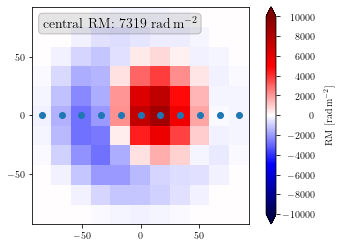

In [152]:
R = 93
B0 = 8.3
theta = 0
phi = 0

rm = make_3d(R, B0, 225, 0, 'half')

In [33]:
rm[5, 5]

7319.245324476439

In [80]:
cbticks = np.arange(-1e4, +1e4, step=2e3, dtype=int)

In [115]:
cbticks

array([-10000,  -8000,  -6000,  -4000,  -2000,      0,   2000,   4000,
         6000,   8000])